# Tutorial 2: Creating an Injection

This tutorial demonstrates how to create a 3-detector gravitational wave injection using `cogwheel` methods and visualize it with a spectrogram.


Import required libraries and set up the output directory.


In [ ]:
import sys

sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from cogwheel import data, gw_utils

# Set up artifacts directory for all outputs
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)


## Create 3-Detector Event Data

Create synthetic Gaussian noise data for three detectors (HLV: Hanford, Livingston, Virgo).


## Inject Signal

Inject the gravitational wave signal into the event data using the `IMRPhenomXPHM` approximant.


In [2]:
# Injection parameters
chirp_mass = 10.0
q = 0.7

# Transform chirp_mass and q to m1, m2
m1, m2 = gw_utils.mchirpeta_to_m1m2(
    chirp_mass, gw_utils.q_to_eta(q)
)

print(f"Chirp mass: {chirp_mass}")
print(f"Mass ratio q: {q}")
print(f"m1: {m1:.2f} M_sun")
print(f"m2: {m2:.2f} M_sun")


Chirp mass: 10.0
Mass ratio q: 0.7
m1: 13.77 M_sun
m2: 9.64 M_sun


In [3]:
# Create injection parameter dictionary
injection_par_dic = dict(
    m1=m1,
    m2=m2,
    ra=0.0,
    dec=0.3,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.6,  
    s2z=0.6,  
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=1000.0, 
    t_geocenter=0.0,
)

print("Injection parameters:")
print(f"  Masses: m1={injection_par_dic['m1']:.2f}, m2={injection_par_dic['m2']:.2f}")
print(f"  Spins: s1z={injection_par_dic['s1z']}, s2z={injection_par_dic['s2z']}")
print(f"  In-plane spins: s1x_n={injection_par_dic['s1x_n']}, s1y_n={injection_par_dic['s1y_n']}, s2x_n={injection_par_dic['s2x_n']}, s2y_n={injection_par_dic['s2y_n']}")
print(f"  Distance: {injection_par_dic['d_luminosity']} Mpc")


# Create cogwheel EventData object
# Create 3-detector event data
event_data_kwargs = {
    "detector_names": "HLV",  # Hanford, Livingston, Virgo
    "duration": 120.0,
    "asd_funcs": ["asd_H_O3", "asd_L_O3", "asd_V_O3"],
    "tgps": 0.0,
    "fmax": 1600.0,
}

eventname = "tutorial_injection"

event_data = data.EventData.gaussian_noise(
    eventname=eventname, **event_data_kwargs, seed=20250311
)

print(f"\nCreated event data: {eventname}")
print(f"Detectors: {event_data.detector_names}")
print(f"Duration: {event_data_kwargs['duration']} seconds")


# Inject signal using IMRPhenomXPHM approximant
approximant = "IMRPhenomXPHM"

# Set global random seed before injection for reproducibility

event_data.inject_signal(injection_par_dic, approximant)
print(f"Injected signal using {approximant}")
lnlike_per_detector = event_data.injection["d_h"] - 1/2 * event_data.injection["h_h"]
print(f"SNR^2 per detector (HLV): {2 * lnlike_per_detector}")
print(f"total SNR: {np.sqrt(2 * lnlike_per_detector.sum()):.2f}")


Injection parameters:
  Masses: m1=13.77, m2=9.64
  Spins: s1z=0.6, s2z=0.6
  In-plane spins: s1x_n=0.1, s1y_n=0.2, s2x_n=0.3, s2y_n=-0.2
  Distance: 1000.0 Mpc

Created event data: tutorial_injection
Detectors: ('H', 'L', 'V')
Duration: 120.0 seconds
Injected signal using IMRPhenomXPHM
SNR^2 per detector (HLV): [34.16370878 59.81746178  5.95692726]
total SNR: 10.00


## Plot Spectrogram

Visualize the injected signal using a spectrogram, which shows the frequency content over time.


/var/folders/y0/kb12lzkd503c0127skcp4h_r0000gp/T/ipykernel_31742/111920634.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


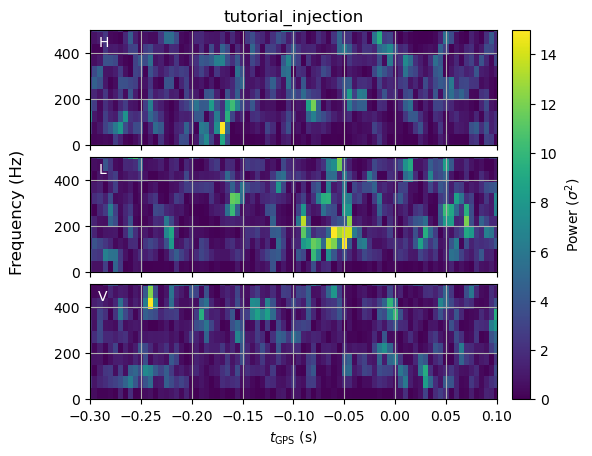

In [4]:
# Plot spectrogram using event_data.specgram
fig = event_data.specgram(xlim=(-0.3, +0.1), vmax=15, nfft=64, noverlap=16)
plt.tight_layout()
plt.ylim(0, 500)
plt.show()

## Plot injection on top of data


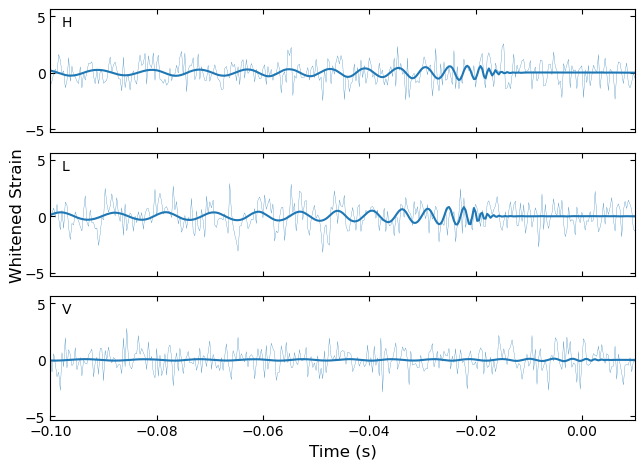

In [5]:

from cogwheel.likelihood import CBCLikelihood
from cogwheel.waveform import WaveformGenerator
# Create COGWHEEL objects: 
# A waveform generator to generate the waveform
# A likelihood object that can handle the waveform generator and the 
# data itself, and use them evaluate likelihoods or other manipulations

waveform_generator = WaveformGenerator.from_event_data(event_data, approximant,)
cbc_likelihood = CBCLikelihood(event_data=event_data, waveform_generator=waveform_generator)

fig = cbc_likelihood.plot_whitened_wf(
    event_data.injection["par_dic"], trng=(-0.1, 0.01)
)


## Save Event Data (Optional)

Save the event data to a file for later use.


In [ ]:
# Save event data
event_path = ARTIFACTS_DIR / f"{eventname}.npz"
event_data.to_npz(filename=event_path)
print(f"Saved event data to: {event_path}")


Saved event data to: artifacts/02_create_injection/tutorial_injection.npz
